# Back Propagation

Here is an implementation of the basic back propagation algorithm. This is meant for educational purposes and should not be used in any production environment.

In this notebook, we will implement our back propagation algorithm using gradient descent and Relu non-linearities through a small network. We will also test our back propagation implementation against a simple problem of approximating mathematical functions.

I will not explain in detail the mathematics and reasoning of the implementation, but will link to external sources that do a sufficient job at doing so. [Here](http://neuralnetworksanddeeplearning.com/chap2.html) is a good place to start for getting a foundation of back propagation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

All the models to learn in this network will take 2 inputs and give 1 output. The output is a classification variable that can take on a value between 0 and 1. Values closer to 0 indicate preference for class 0 while values for class 1 prefer class 1.

We will define 3 functions that our neural networks should learn after training:

## Model 1: Inside of Ellipsis

In [2]:
num_points = 10000

In [3]:
def create_ellipse_func(a, b):
    def ellipse_func(x, y):
        return 1 if ((x*x) / (a*a) + (y*y) / (b*b)) <= 1 else 0

    return ellipse_func


In [4]:
model1_func = create_ellipse_func(2.0, 4.0)
model1_points = 8 * np.random.rand(2, num_points) - 4
model1_categories = np.apply_along_axis(lambda x: model1_func(x[0], x[1]), axis=0, arr=model1_points)

split_mask = np.random.rand(num_points) <= 0.6

model1_training = model1_points[:, split_mask]
model1_training_categories = model1_categories[split_mask]

model1_test = model1_points[:, ~split_mask]
model1_test_categories = model1_categories[~split_mask]

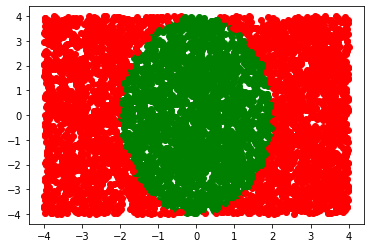

In [5]:
# Let's make a plot to see where the ellipse is being drawn.

for i in range(len(model1_training_categories)):
    point = model1_training[:, i]
    category = model1_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Model 2: Guassian

In [6]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


In [7]:
model2_func = create_gaussian_curve(0.0, 0.05)
model2_points = np.random.rand(2, num_points) * 4 - 2
model2_categories = np.apply_along_axis(lambda x: model2_func(x[0], x[1]), axis=0, arr=model2_points)

split_mask = np.random.rand(num_points) <= 0.6

model2_training = model2_points[:, split_mask]
model2_training_categories = model2_categories[split_mask]

model2_test = model2_points[:, ~split_mask]
model2_test_categories = model2_categories[~split_mask]

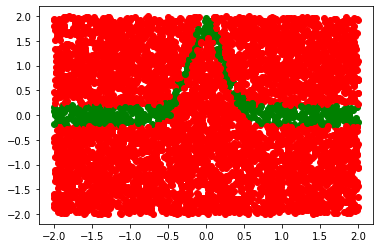

In [8]:
# Let's make a plot to see where the ellipse is being drawn.

for i in range(len(model2_training_categories)):
    point = model2_training[:, i]
    category = model2_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Feed Forward Network

We will design a simple feed-forward network with relu activation.

### Activation Functions

In [9]:
def relu(X):
    mask = X >= 0
    return X * mask
    

In [10]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [11]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [12]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [13]:
def binary_cross_entropy_loss(output, expected):
    # Note that this function will throw errors if any of the output
    # values are 0 or 1 exactly.
    m = output.shape[1]

    # Offset the output if there are any values exactly equal to
    # zero or one to avoid log(0).
    zero_correct = (output == 0).astype(float) * 1e-10 
    one_correct = (output == 1).astype(float) * (-1e-10)
    output = output + zero_correct + one_correct

    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output)) / m


In [14]:
def binary_cross_entropy_loss_grad(output, expected):
    # Note that this function will throw errors if any output is 0.
    m = output.shape[1]
    return (1. / m) * ((expected / output) - (1 - expected) / (1 - output))


### Defining the Model

In [15]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers
    

In [17]:
def forward(model, X):
    Y = X

    linear_outputs = []
    outputs = []

    for (i, (weights, biases)) in enumerate(model['layers'][0:-1]):
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    if 'no_grad' not in model or not model['no_grad']:
        model['linear_outputs'] = linear_outputs
        model['input'] = X
        model['outputs'] = outputs
        model['result'] = Y

    return Y
 

In [18]:
def loss(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.
    result = model['result']
    loss = binary_cross_entropy_loss(result, expected)
    
    if 'no_grad' not in model or not model['no_grad']:
        model['loss'] = loss

    return loss


In [19]:
def backward(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    X = model['input']
    result = model['result']

    L = len(layers)
    m = result.shape[1] # Number of samples.

    # Note: We can have multiple samples in the outputs, so we
    # will end up with a gradient per sample.
    output_prev_layer = X if len(outputs) <= 1 else outputs[-2]
    loss_grad = binary_cross_entropy_loss_grad(result, expected)
    error_last_layer = loss_grad * sigmoid_deriv(linear_outputs[-1])
    bias_grad_last_layer = np.sum(error_last_layer, axis=1).reshape(-1, 1)
    weights_grad_last_layer = np.dot(error_last_layer, output_prev_layer.T) # outer product
    grad_last_layer = (weights_grad_last_layer, bias_grad_last_layer)

    errors = [error_last_layer]
    grads = [grad_last_layer]
    
    # Enumerate layers in reverse order to compute errors
    # and gradients.
    for i in range(L - 2, -1, -1):
        linear_output = linear_outputs[i]
        output_prev_layer = X if i == 0 else outputs[i-1]
        error_next_layer = errors[-1]
        weights_next_layer, bias_next_layer = layers[i+1]

        error = np.dot(weights_next_layer.T, error_next_layer) * sigmoid_deriv(linear_output)
        bias_grad = np.sum(error, axis=1).reshape(-1, 1)
        weights_grad = np.dot(error, output_prev_layer.T)
        
        errors.append(error)
        grads.append((weights_grad, bias_grad))
        
    # Reverse the order of errors and gradients so they go from
    # first layer to last.
    errors.reverse()
    grads.reverse()
    
    if 'no_grad' not in model or not model['no_grad']:
        model['errors'] = errors
        model['grads'] = grads
    
    return grads, errors


In [20]:
def step_SGD(model, lr=0.1):
    # Note: We are assuming the model has already gone
    # through back propagation and all the gradients have
    # been calculated.
    
    new_layers = []

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]
        
        weight = weight + (lr * grad_weight)
        bias = bias + (lr * grad_bias)

        model['layers'][i] = (weight, bias)


In [21]:
def no_grad(model):
    model['no_grad'] = True


In [22]:
def grad(model):
    model['no_grad'] = False

In [23]:
def clear(model):
    """
    Clear any state that has been saved to the model
    during training.
    """
    keys = ['errors', 'grads', 'input', 'linear_outputs', 'loss', 'loss_grads', 'outputs', 'result']
    
    for key in keys:
        if key in model:
            del model[key]
    

In [24]:
def predict(model, X, threshold=0.5):
    should_toggle_no_grad = 'no_grad' in model and model['no_grad']
    
    if should_toggle_no_grad:
        no_grad(model)

    Y = forward(model, X)
    
    if should_toggle_no_grad:
        grad(model)

    return (Y >= threshold).astype(float)


## Creating and Training the Model

### Model 1

In [39]:
model1 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[3, 4]) }


In [40]:
X = model1_training
Y = model1_training_categories

epochs = 10000
batch_size = 1000
n = model1_training.shape[1]

model1_train_errors = []
model1_test_errors = []

for i in range(epochs):
    for (batch_i, batch_start) in enumerate(range(0, n, batch_size)):
        batch_X = X[:, batch_i:min(n, batch_start+batch_size)]
        batch_Y = Y[batch_i:min(n, batch_start+batch_size)]

        forward(model1, batch_X)
        backward(model1, batch_Y)
        step_SGD(model1, lr=0.01)

    
    # Turn off gradient checking while we calculate training
    # and test loss.
    no_grad(model1)

    if i % 10 == 0:
        train_output = forward(model1, X)
        train_error = binary_cross_entropy_loss(train_output, Y)

        test_output = forward(model1, model1_test)
        test_error = binary_cross_entropy_loss(test_output, model1_test_categories)
        
        model1_train_errors.append(train_error)
        model1_test_errors.append(test_error)

        if i % 100 == 0:
            print(f'Train Error {train_error}')
            
            for weight,_ in model1['layers']:
                max_weight = np.amax(np.abs(weight))
                min_weight = np.amin(np.abs(weight))
                closest_to_inf_weight = max(max_weight, closest_to_inf_weight)
                closest_to_zero_weight = min(min_weight, closest_to_zero_weight)
                
            print(f'Largest Weight: {closest_to_inf_weight}, Smallest Weight: {closest_to_zero_weight}')
    
    # Turn gradient checking back on before we start a new epoch.
    grad(model1)


Train Error 0.6861405305313063
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.6122434225660911
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.604033559503188
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.5978348325281083
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.5800780381201542
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.5486307486734333
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.5115602011399046
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.48059937557256716
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.45654433736763333
Largest Weight: 4.353133863364874, Smallest Weight: 0.0001920262788514297
Train Error 0.43606014235186347
Largest Weight: 4.3531

Train Error 0.08054456395907353
Largest Weight: 5.536418881562504, Smallest Weight: 0.0001920262788514297
Train Error 0.08010336515805479
Largest Weight: 5.554134681804654, Smallest Weight: 0.0001920262788514297
Train Error 0.07967554871328682
Largest Weight: 5.571821567268721, Smallest Weight: 0.0001920262788514297
Train Error 0.07926927553838362
Largest Weight: 5.5894674328103875, Smallest Weight: 0.0001920262788514297
Train Error 0.07888421138028902
Largest Weight: 5.607056298497989, Smallest Weight: 0.0001920262788514297
Train Error 0.0785135903851282
Largest Weight: 5.624571729390148, Smallest Weight: 0.0001920262788514297
Train Error 0.07814646716948326
Largest Weight: 5.642014159553836, Smallest Weight: 0.0001920262788514297
Train Error 0.07776731269910044
Largest Weight: 5.659399139751503, Smallest Weight: 0.0001920262788514297
Train Error 0.077384340519667
Largest Weight: 5.6767393803041575, Smallest Weight: 0.0001920262788514297
Train Error 0.07700656046638686
Largest Weight:

### Model 2

In [47]:
model2 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[3, 4]) }


In [48]:
X = model2_training
Y = model2_training_categories

epochs = 100000
batch_size = 1000
n = model2_training.shape[1]

model2_train_errors = []
model2_test_errors = []

for i in range(epochs):
    for (batch_i, batch_start) in enumerate(range(0, n, batch_size)):
        batch_X = X[:, batch_i:min(n, batch_start+batch_size)]
        batch_Y = Y[batch_i:min(n, batch_start+batch_size)]

        forward(model2, batch_X)
        backward(model2, batch_Y)
        step_SGD(model2, lr=0.01)

    
    # Turn off gradient checking while we calculate training
    # and test loss.
    no_grad(model2)

    if i % 10 == 0:
        train_output = forward(model2, X)
        train_error = binary_cross_entropy_loss(train_output, Y)

        test_output = forward(model2, model2_test)
        test_error = binary_cross_entropy_loss(test_output, model2_test_categories)
        
        model2_train_errors.append(train_error)
        model2_test_errors.append(test_error)

        if i % 100 == 0:
            print(f'Train Error {train_error}')
            
            for weight,_ in model2['layers']:
                max_weight = np.amax(np.abs(weight))
                min_weight = np.amin(np.abs(weight))
                closest_to_inf_weight = max(max_weight, closest_to_inf_weight)
                closest_to_zero_weight = min(min_weight, closest_to_zero_weight)
                
            print(f'Largest Weight: {closest_to_inf_weight}, Smallest Weight: {closest_to_zero_weight}')
    
    # Turn gradient checking back on before we start a new epoch.
    grad(model2)


Train Error 0.8746127612251545
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.34506976596799077
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.3289958125514902
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.3248035311103529
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.3223549170959856
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.32073908021759445
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.3196686115030276
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.3189825270861738
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.31856561674539197
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.3183164180373747
Largest Weight: 5.896548777161

Train Error 0.30096197556417914
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.30060286860523194
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.3002540159302934
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.29991410576638106
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.29958251830362265
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2992626443987068
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.298952391017693
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2986514289467242
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.29835886305994913
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2980758017278418
Largest Weight: 5.89654877716

Train Error 0.28054548183788547
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.28029011093126166
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.28003385009427095
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2797772478543879
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.27952052835358565
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.27926238947724863
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2790049316308428
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.27875007052892997
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.27849337944746577
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2782369088767942
Largest Weight: 5.89654877

Train Error 0.2630074155820189
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.26283782762728636
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2626650485210897
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2624917784069998
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.26232356396751944
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2621622452869654
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.262004465776631
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2618501517884806
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2617002145331933
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.26155296572224757
Largest Weight: 5.8965487771614

Train Error 0.22929398529421752
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.22737951388695607
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.22553768122189277
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2237596823469321
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2221132722763954
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.22055713801370136
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.21915070565046474
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2178493747869359
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.21664250200674726
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.21559924495439817
Largest Weight: 5.89654877

Train Error 0.19785374305997097
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.19793008494024375
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.19801491771782312
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1981119213991703
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.19821698267986324
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.19832694863347003
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.19843527174576958
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.19854594214225638
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.19866070335171637
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1987830304973945
Largest Weight: 5.8965487

Train Error 0.2023779602296276
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.20222502717776222
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.20206730176450866
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.2019011064495821
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.20172327359058065
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.20153935064634831
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.20134681357002923
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.20114497088055608
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.20093685720087032
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.200728472568332
Largest Weight: 5.896548777

Train Error 0.18606004440240528
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.18576417513494545
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.18547268600653016
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1851890657968678
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1849086798775353
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1846316879255793
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.18434434855919204
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.18405469192848933
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1837533908910087
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1834480477994976
Largest Weight: 5.8965487771

Train Error 0.16219857730374532
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.16202473813560717
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1618571306001242
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.16169865985662735
Largest Weight: 5.896548777161467, Smallest Weight: 0.000155618898229563
Train Error 0.1615479021605887
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1614028160530322
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.16126043379497523
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.16112566168457645
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.16099782021647005
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.16087700425657378
Largest Weight: 

Train Error 0.15816085460216114
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1581408306501889
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15811998679610215
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15809749407393853
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15807345703693768
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15804992419287808
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15802662325064215
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1580011705285483
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1579743905795918
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15794773783231603
Largest 

Train Error 0.15682862415852716
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15682100713191033
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1568141697731452
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15680729032461213
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15680045467173329
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1567937707242529
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15678766275565448
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1567823687137066
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15677697033823992
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15677151241519247
Largest 

Train Error 0.15659479636332052
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15658968820550392
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15658474905972747
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15658004594762354
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15657621538411348
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15657245141583118
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15656866460082133
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15656504915734865
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15656139088926757
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15655776639545457
Large

Train Error 0.1562382037704481
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15623681850453774
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15623556334961372
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15623432358617084
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1562330839067669
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15623193637109437
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15623081582162826
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1562297947236433
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.1562289078162561
Largest Weight: 5.896548777161467, Smallest Weight: 0.00014352673806299824
Train Error 0.15622843052175076
Largest W

## Viewing the Results

### Model 1

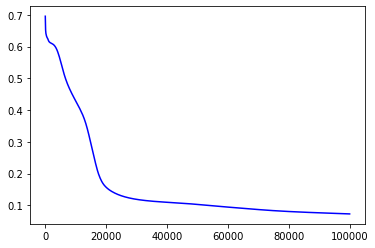

In [41]:
x = [i*100 for i in range(len(model1_train_errors))]

# plt.plot(x, model1_train_errors, 'green')
plt.plot(x, model1_test_errors, 'blue')
plt.show()

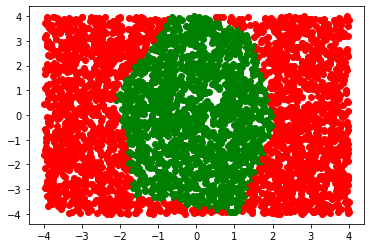

In [42]:
n = model1_test.shape[1]

for i in range(n):
    point = model1_test[:, i].reshape(-1, 1)
    category = predict(model1, point)
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

### Model 2

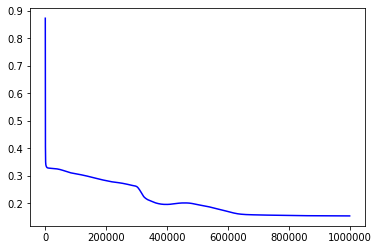

In [49]:
x = [i*100 for i in range(len(model2_train_errors))]

# plt.plot(x, model2_train_errors, 'green')
plt.plot(x, model2_test_errors, 'blue')
plt.show()

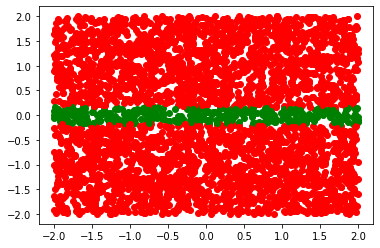

In [50]:
n = model2_test.shape[1]

for i in range(n):
    point = model2_test[:, i].reshape(-1, 1)
    category = predict(model2, point)
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

**NOTE: While our second model did show improvement, it failed to learn the curve of the guassian function. I will continue to explore this more in a separate notebook.**